# Combustion Chemistry in Isobaric Reactor: Postprocessing DeepONet

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing External Libraries

import numpy                             as np
import pandas                            as pd
from   numpy                         import diff
import                           cantera as ct

### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
# import pyDOE
# from PCAfold         import PCA          as PCAA


import romnet                            as rmnt


# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


In [2]:
DataDir          = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/0DReact_Isobaric_500Cases_H2_Sources/')

path_to_run_fld  = os.path.join(WORKSPACE_PATH, 'ROMNet/0DReact_Isobaric_500Cases_H2_Sources/FNN/Run_2/')

FigDir           = os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_FNN/')


# DataType         = 'train'
# CasesVec         = range(0,500,100)
DataType         = 'test'
CasesVec         = range(10) #[1,0,2]



NSamples         = 100

NVarsRed         = 10

FixedMinVal      = 1.e-14 

PCA_NAME         = 'All'

scale            = 'lin'
MinVal           = 1.e-40

 
ColorVec         = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']
LineVec          = ['-',':','--','.-']*10

## Loading ROMNet's Input Data File

In [3]:
print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH)


InputData.InputFilePath = path_to_run_fld+'/ROMNet_Input.py'
InputData.train_int_flg = 0
InputData.path_to_run_fld  = path_to_run_fld


[ROMNet]: Reading Input File from:  /Users/sventur/WORKSPACE/ROMNet/romnet/extra/Untitled Folder/../../../../ROMNet/0DReact_Isobaric_500Cases_H2_Sources/FNN/Run_2/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


## Loading Tensorflow's Model for the Network 

In [4]:
surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.nn, surrogate_type)

model = rmnt.model.Model_TF(InputData)

if (InputData.phys_system is not None):
    System = getattr(rmnt.pinn.system, InputData.phys_system)
    system = System(InputData)
    
model.build(InputData, None, Net, system)#, loadfile_no='000027')

NN    = model.net


[ROMNet - model_tf.py    ]:   Initializing the ML Model

[ROMNet - model_tf.py    ]:   Building the ML Model

[ROMNet - fnn.py                    ]:   Constructing Feed-Forward Network: 
[ROMNet - system_of_components.py   ]:     Constructing System of Components: FNN
[ROMNet - component.py              ]:       Constructing Component: FNN
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<romnet.nn.building_blocks.normalization.CustomNormalization object at 0x168e22c40>, <keras.layers.core.dense.Dense object at 0x1692d23a0>, <keras.layers.core.dense.Dense object at 0x1691b5d30>, <keras.layers.core.dense.Dense object at 0x1692a05e0>, <keras.layers.core.dense.Dense object at 0x1692c6d60>, <keras.layers.core.dense.Dense object at 0x1692c65b0>, <keras.layers.core.dense.Dense object at 0x1692c6be0>])

[ROMNet - model_tf.py    ]:   Loading ML Model Parameters from File:  /Users/sventur/WORKSPACE/ROMNet/romnet/extra/Untitled Folde

## Evaluating DeepONet on Test Data

### Loading Simulations Info

In [5]:
# FileName     = DataDir + '/Orig/train/ext/y.csv.1'
# Data         = pd.read_csv(FileName, header=0)
# VarNames     = list(Data.columns)
# VarNames.remove('t')

# FileName     = DataDir + '/Orig/train/ext/CleanVars.csv'
# Data         = pd.read_csv(FileName, header=0)
# VarNamesAnti = list(Data.columns)
    
# SVars = []
# for iVars in range(1,NVarsRed+1):
#     SVars.append('SPC_'+str(iVars))


# FileName     = DataDir + '/Orig/'+DataType+'/ext/SimIdxs.csv'
# Data         = pd.read_csv(FileName, header=0)
# SimIdxs      = Data.to_numpy(int)

# FileName     = DataDir + '/Orig/'+DataType+'/ext/ICs.csv'
# Data         = pd.read_csv(FileName)
# ICVecs       = Data.to_numpy()
# n_ics         = len(ICVecs)

### Loading PCA's Matrixes and Info

In [6]:
FileName = DataDir+'/'+str(NVarsRed)+'PC/ROM/A.csv'
A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()
AT       = A.T

FileName = DataDir+'/'+str(NVarsRed)+'PC/ROM/C.csv'
C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy().T

FileName = DataDir+'/'+str(NVarsRed)+'PC/ROM/D.csv'
D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy().T

FileName    = DataDir+'/'+str(NVarsRed)+'PC/ROM/ToOrig_Mask.csv'
ToOrig_Mask = pd.read_csv(FileName, delimiter=',', header=None).to_numpy(int)[:,0]


InputVars = []
for iVars in range(1,NVarsRed+1):
    InputVars.append('PC_'+str(iVars))

OutputVars = []
for iVars in range(1,NVarsRed+1):
    OutputVars.append('SPC_'+str(iVars))

### Loading and Plotting Test/Training Data

In [7]:
FileName     = DataDir+str(NVarsRed)+'PC/'+DataType+'/ext/PC.csv'
InputData    = pd.read_csv(FileName, header=0)

FileName     = DataDir+str(NVarsRed)+'PC/'+DataType+'/ext/PCSource.csv'
OutputData   = pd.read_csv(FileName, header=0)
ydot_Data    = OutputData.to_numpy()

In [8]:
ydot_Pred    = model.predict(InputData)

In [ ]:
iPC          = 0

plt.scatter(ydot_Data[:,iPC], ydot_Pred[:,iPC], s=30)

axes = plt.gca()
xlim = axes.get_xlim()
ylim = axes.get_ylim()
plt.plot([np.minimum(xlim[0],ylim[0]), np.maximum(xlim[1],ylim[1])], [np.minimum(xlim[0],ylim[0]), np.maximum(xlim[1],ylim[1])])

plt.xscale('log')
plt.yscale('log')

## Plotting Loss Histories

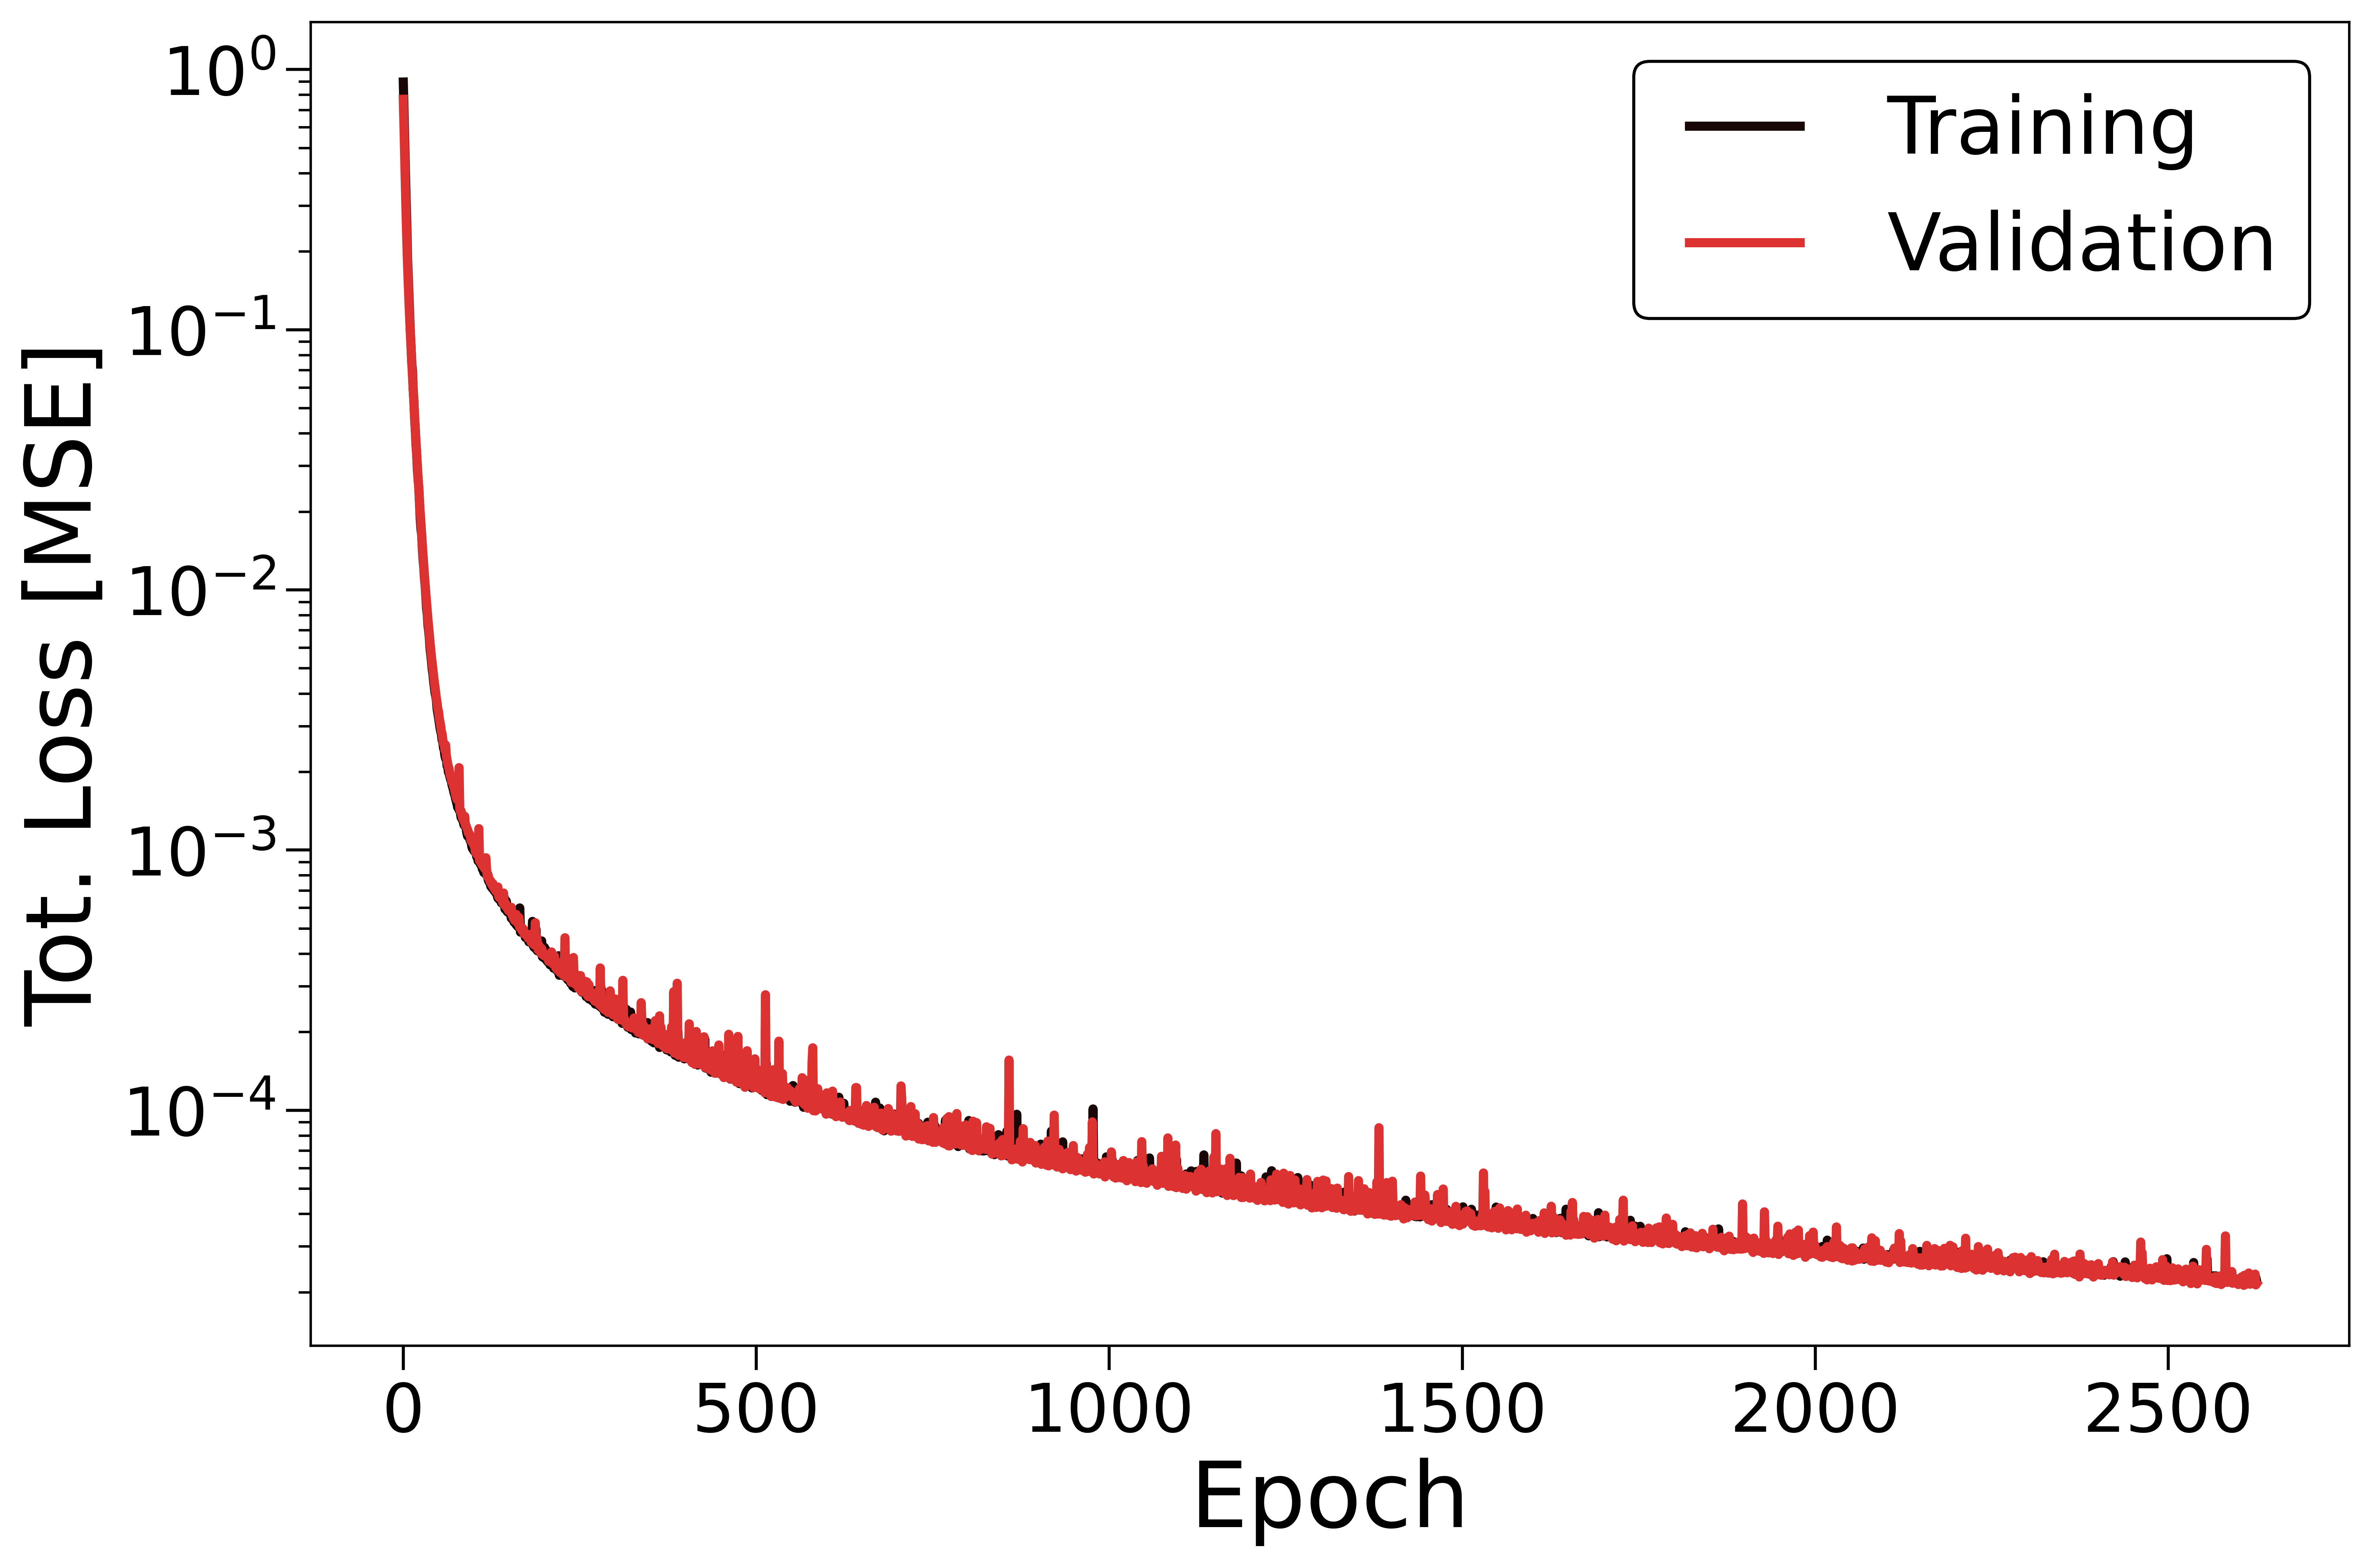

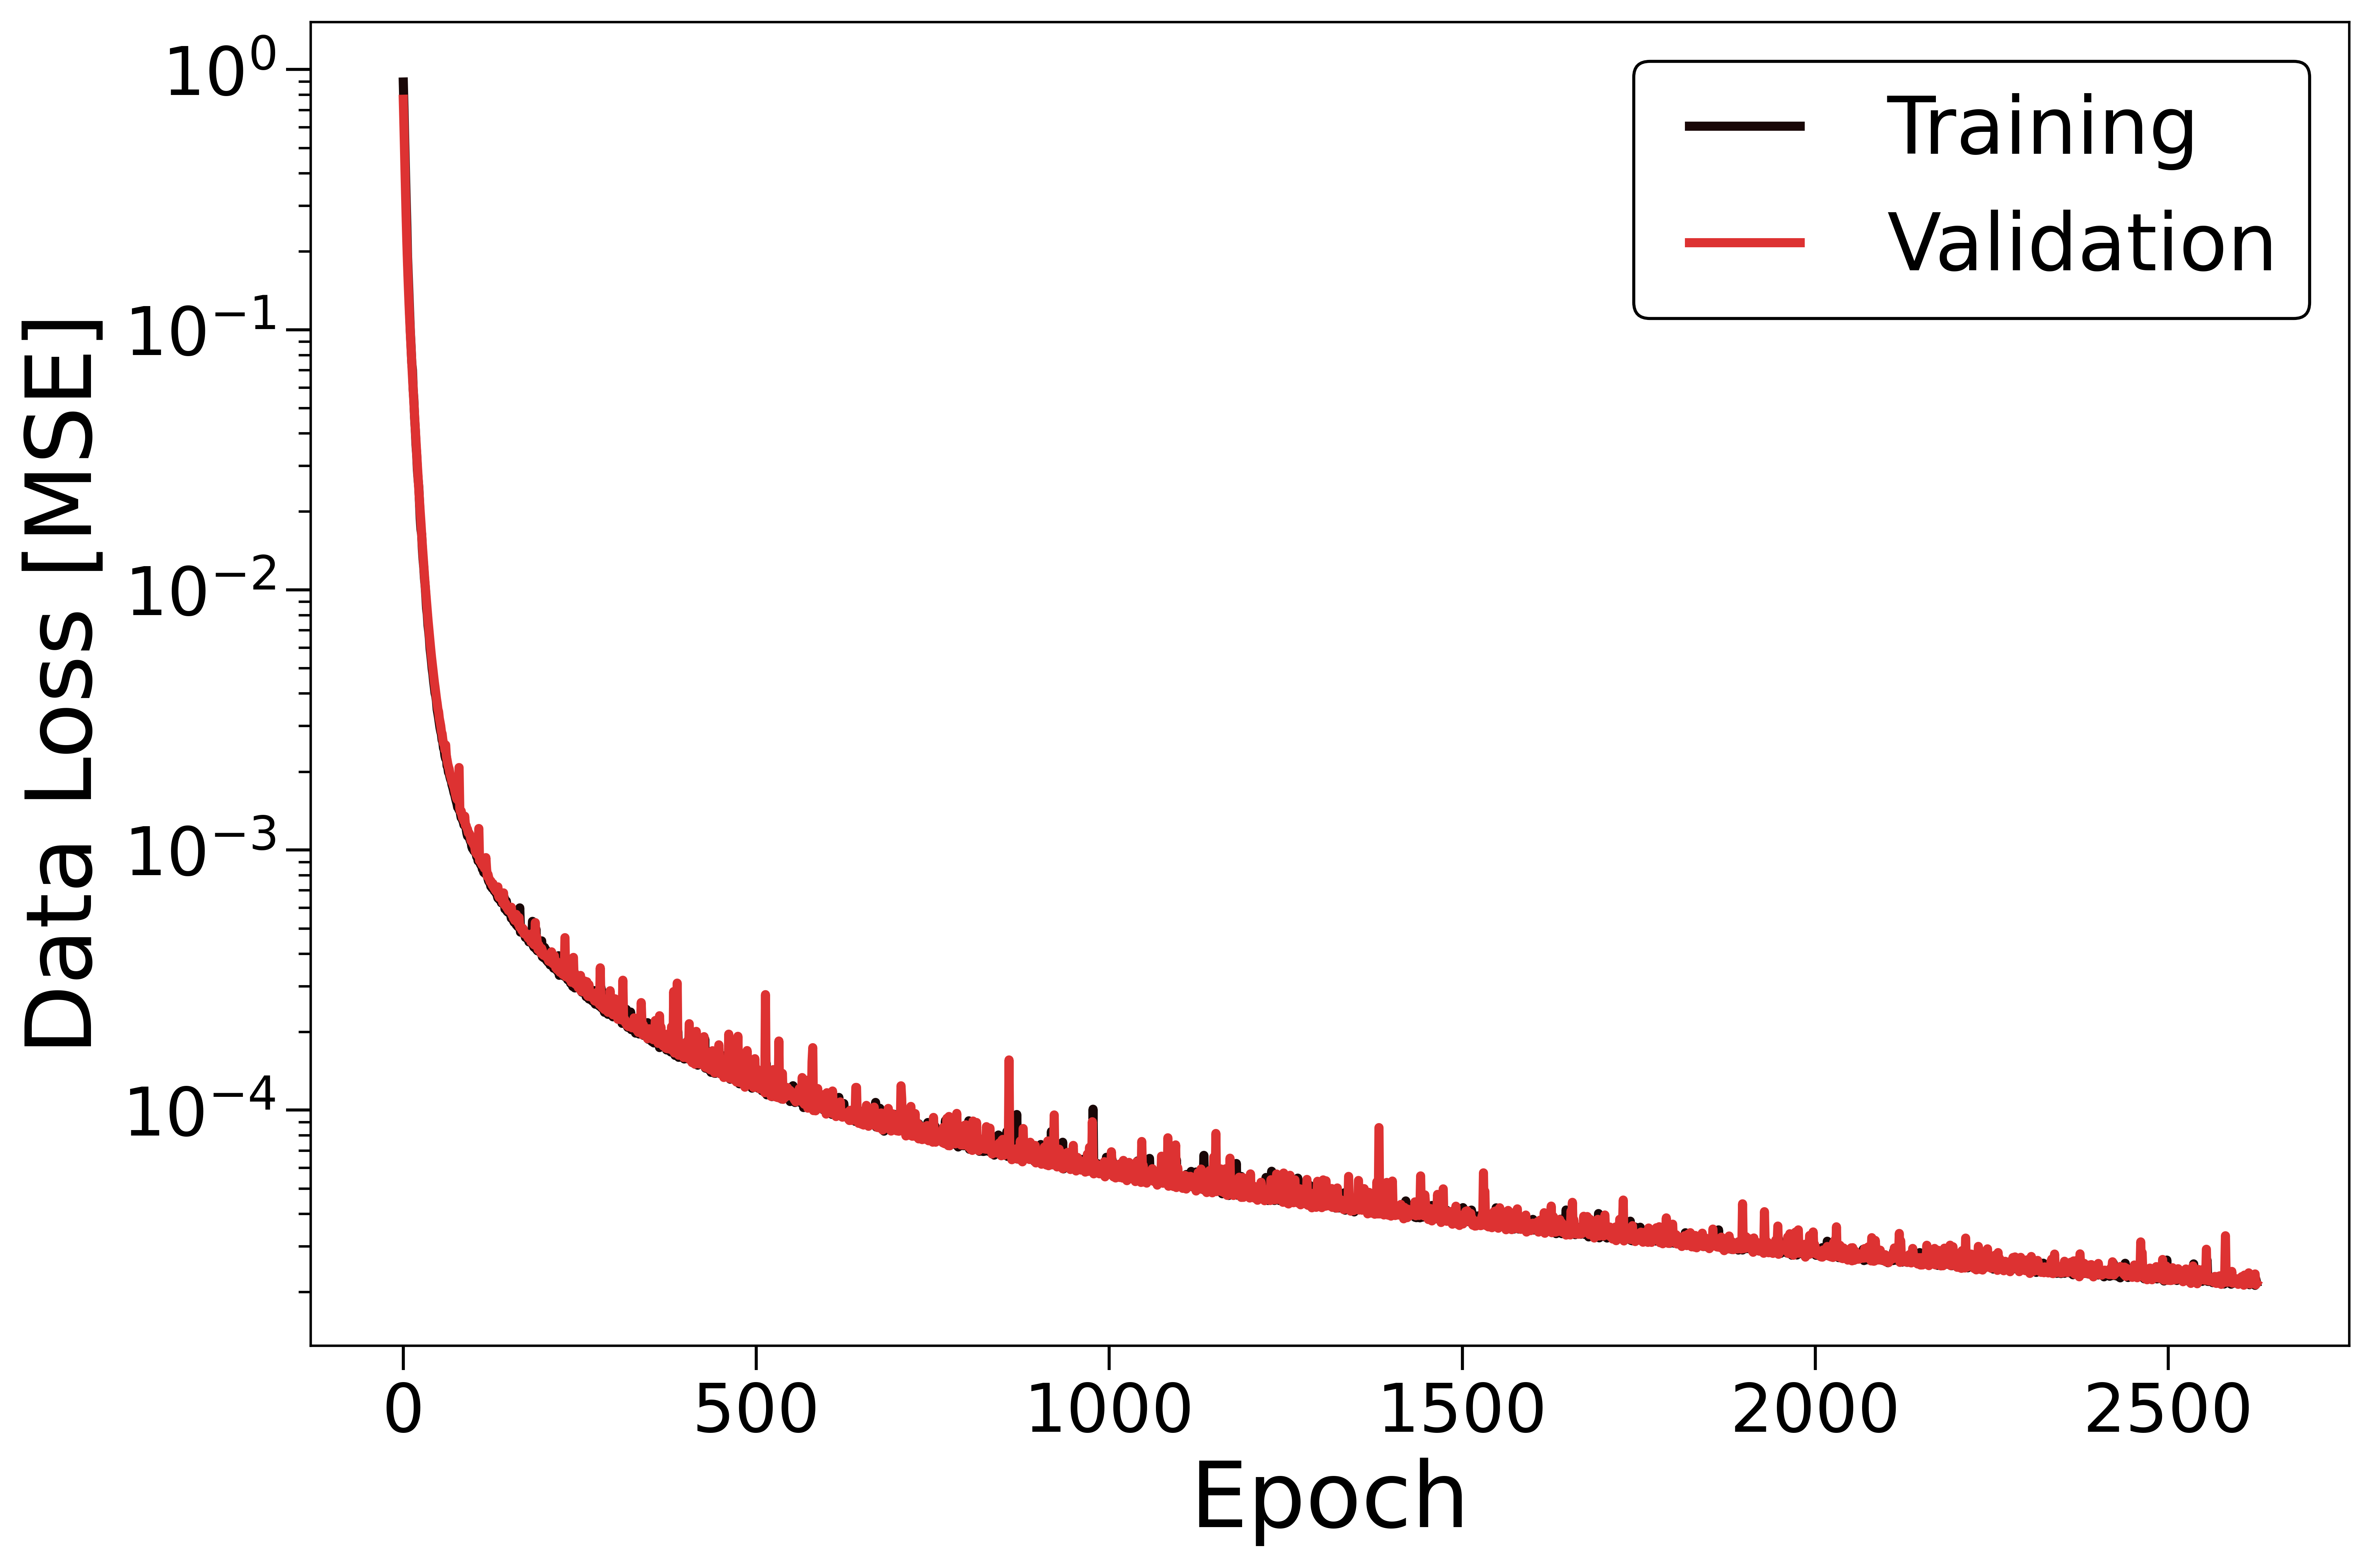

In [10]:
Data = pd.read_csv(path_to_run_fld+'/Training/History.csv')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['tot_loss'],     label='Training')
plt.plot(Data['val_tot_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['res_loss'],     label='Training')
# plt.plot(Data['val_res_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('Residual Loss [MSE]')
# plt.legend()
# plt.yscale('log')


fig  = plt.figure(figsize=(12,8))
plt.plot(Data['pts_loss'],     label='Training')
plt.plot(Data['val_pts_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['scs_loss'],     label='Training')
# plt.plot(Data['val_scs_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('S.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')


# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

## Compare to Time Integration

In [11]:
iTest = 2

FileName         = DataDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iTest)
Data             = pd.read_csv(FileName, header=0)
tVec             = Data.to_numpy()[:,0] - Data.to_numpy()[0,0]
tVec[tVec == 0.] = FixedMinVal
yPCA_Data        = Data[InputVars].to_numpy()
Data0            = Data[Data['t'] > 1.e-14][InputVars]

In [12]:
##########################################################################################
### Defining ODE and its Parameters
def SourceTerm_TF(t, y):
    #print(t)
    
    ydot = model.predict(y[np.newaxis,...])
    
    return ydot[0,:]

In [ ]:
y0     = Data0.to_numpy()[0,:]
tVec   = np.logspace(-7,-3,5000)
output = solve_ivp( SourceTerm_TF, (tVec[0],tVec[-1]), y0, method='BDF', t_eval=tVec, rtol=1.e-12, atol=1.e-8 )

tVec_Pred = output.t
yPCA_Pred = output.y.T

In [ ]:
iPC    = 0

plt.figure()
plt.plot(tVec,      yPCA_Data[:,iPC])
plt.plot(tVec_Pred, yPCA_Pred[:,iPC])
plt.xscale('log')

In [ ]:
FileName         = DataDir+'/Orig/train/ext/CleanVars.csv'
CleanVars        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()[0,:]

FileName         = DataDir+'/Orig/train/ext/ySource.csv.'+str(iTest)
Data             = pd.read_csv(FileName)
yDot_Data        = Data[CleanVars].to_numpy()
tVec_Dot         = Data['t'].to_numpy()

In [ ]:
yDotPCA_Data     = (yDot_Data/D).dot(AT) 